# Biochemical fermenter

 *************** Created by Pablo Borja *******************
 
 ***** Contact: pablo.borjarosales@plymouth.ac.uk ***** 
 
 ***** SECaM, Univerity of Plymouth, Plymouth, UK ***** 
 

Importing packages...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Parameters for simulation

The values of the system parameters are taken from:

~~~~~~~~~~~~~~~~

 Dörfler, F., Johnsen, J. K., & Allgoewer, F. (2009).
 An introduction to interconnection and damping assignment passivity-based control in process engineering.
 Journal of Process Control, 19(9), 1413-1426.

~~~~~~~~~~~~~~~~

In [3]:
Y = 0.5;
mu_max = 1;
Sf = 10;
c1 = 0.03;
c2 = 0.5;

We define the desired equilibrium below. Modify if necessary. Remember to satisfy 

$$\frac{x_{1_{\tt d}}}{Y}+x_{2_{\tt d}} = S_{\tt f}$$


In [4]:

x1d = 4.8;
x2d = Sf - x1d/Y;


In [5]:
y0 = [2.8, 4.4];

In [6]:
t0 = 0;

tf = 5e-5; # Modify if you want to simulate a longer or shorter period

t = np.linspace(t0, tf, 500)

# System (ODE)

Below, we briefly explain how to obtain the closed-loop dynamics. Please see the PDF file "Examples" to understand this part.

================================

The matrices $F(x)$ and $g(x)$ are given by

$$F(x)=\mu x_{1}\begin{bmatrix} -1 & 0 \\ 0 & -\frac{1}{Y x_{2}}  \end{bmatrix} \quad g(x)=\mu x_{1}\begin{bmatrix} -x_{1} \\ S_{\tt f}-x_{2} \end{bmatrix}.$$

The Hamiltonian's gradient is

$$\frac{\partial H(x)}{\partial x} = \begin{bmatrix} -1 \\ x_{2} \end{bmatrix}.$$

Additionally, 

$$\frac{\partial \Phi(\gamma)}{\partial \gamma} = \frac{1}{x_{1_{\tt d}}}+K\left(\gamma(x)-\gamma(x_{\star}) \right)$$

and

$$H_{\tt d}(x) = H(x)+\Phi(\gamma(x)).$$

Hence, the control law reduces to

$$u = \underbrace{-\frac{1}{x_{1_{\tt d}}}-K\left(\gamma(x)-\gamma(x_{\star}) \right)}_{-\frac{\partial \Phi(\gamma)}{\partial \gamma}} - K_{\tt di}g^{\top}(x)\left(\frac{\partial H(x)}{\partial x}+\frac{\partial \Phi(\gamma(x))}{\partial x}\right).$$

To obtain the closed-loop dynamics, we substitute the control law $u$ obtained above into

$$\dot{x} = F(x)\frac{\partial H(x)}{\partial x}+ g(x)u.$$

In [7]:
def fermenter_ode(t, y, Y, mu_max, Sf, c1, c2, x1d, x2d):
    x1, x2 = y
    
    mu = mu_max*x2/(c1+x2+c2*x2**2); # mu(x2)

    F11 = -mu*x1; 
    F22 = -mu*x1/(x2*Y); # Elements of F(x)
    g1 = -mu*x1**2;
    g2 = mu*x1*(Sf-x2); # Elements of g(x)
    nH1 = -1;
    nH2 = x2; # Elements of the Hamiltonian's gradient

    # Control parameters

    gamma = -x1**2/2 + Sf*Y*x2**2/2 - Y*x2**3/3;
    gamma_s = -x1d**2/2 + Sf*Y*x2d**2/2 - Y*x2d**3/3;
    u_s = 1/x1d;

    # Control gains

    K = 5;
    Kdi = 15/(mu*x1); # Modifying the closed-loop damping is necessary to achieve asymptotic stability

    ngPhi = u_s + K*(gamma-gamma_s); # Partial of Φ with respect to γ

    nPhi1 = ngPhi*x1;
    nPhi2 = -ngPhi*(-Sf*Y*x2+Y*x2**2); # Elements of the gradient of Φ with respect to x

    # Gradient of Hd. 
    nHd1 = nPhi1+nH1;
    nHd2 = nPhi2+nH2; 

    # Controller

    u = -ngPhi-Kdi*(g1*nHd1+g2*nHd2)

    return [F11*nH1+g1*u, F22*nH2+g2*u]

# ODE solution

In [8]:
sol_ivp = solve_ivp(fermenter_ode,[t0,tf],y0,args=(Y, mu_max, Sf, c1, c2, x1d, x2d), dense_output=True, rtol = 1e-6, atol = 1e-10)

p = sol_ivp.sol(t)

# Plots

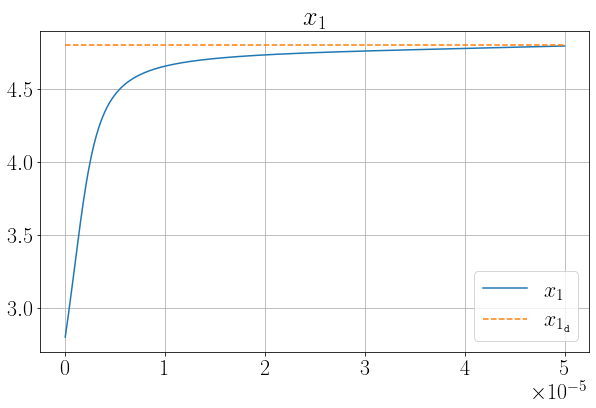

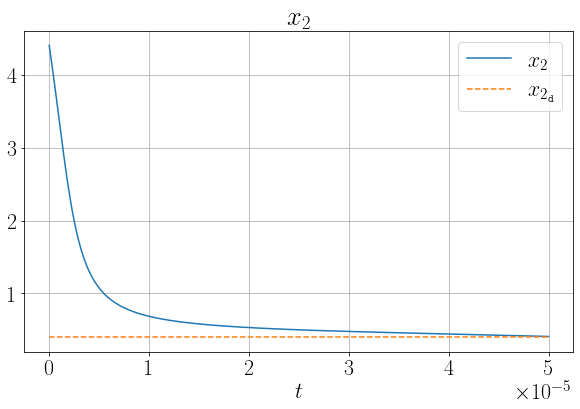

In [9]:
plt.rcParams['text.usetex'] = True

cm = 1/2.54

plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(25*cm, 15*cm))
plt.plot(t, p[0].T, label = '$x_{1}$')
plt.plot([t0,tf], [x1d,x1d],'--',label = '$x_{1_{\\tt d}}$')
plt.title('$x_{1}$')
plt.grid()
plt.legend(loc='best')

plt.figure(figsize=(25*cm, 15*cm))
plt.plot(t, p[1].T,label = '$x_{2}$')
plt.plot([t0,tf], [x2d,x2d],'--',label = '$x_{2_{\\tt d}}$')
plt.title('$x_{2}$')
plt.xlabel('$t$')
plt.legend(loc='best')
plt.grid()
plt.show()